<a href="https://colab.research.google.com/github/sthalles/fishers-linear-discriminant/blob/master/LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from numpy.linalg import pinv
import matplotlib.lines as mlines
plt.rcParams["axes.grid"] = False
# plt.style.use('ggplot')

In [0]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
print(x_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)


In [0]:
two_class_data = []
two_class_target = []
for x, y in zip(x_train, y_train):
  if y == 0 or y == 1:
    two_class_data.append(x.flatten())
    two_class_target.append(y.squeeze())

In [0]:
two_class_data = np.asarray(two_class_data)
two_class_target = np.asarray(two_class_target)
print(two_class_data.shape)
print(two_class_target.shape)

(12665, 784)
(12665,)


In [0]:
cnt = Counter(two_class_target)
cnt

Counter({0: 5923, 1: 6742})

In [0]:
# Compute the number of points of class C1 as N1 and class C2 as N2
N1 = cnt[0]
N2 = cnt[1]
print("# of points from class C1:",N1)
print("# of points from class C2:",N2)

# of points from class C1: 5923
# of points from class C2: 6742


The idea proposed by Fisher is to maximize a function that will give a large separation between the projected class means while also giving a small variance within each class, thereby minimizing the class overlap.

In [0]:
C1_input = []
C1_target = []

C2_input = []
C2_target = []

# separate inputs from class C1 and C2 in different numpy arrays
for i in range(len(two_class_target)):
  y = two_class_target[i]
  x = two_class_data[i]
  if y == 0:
    C1_input.append(x.flatten())
    C1_target.append(y.squeeze())
  elif y == 1:
    C2_input.append(x.flatten())
    C2_target.append(y.squeeze())
    
C1_input = np.asarray(C1_input)
C1_target = np.asarray(C1_target)

C2_input = np.asarray(C2_input)
C2_target = np.asarray(C2_target)

print(C1_input.shape, C1_target.shape)

(5923, 784) (5923,)


In [0]:
# compute the mean vector for each of the 2 classes
# compute the mean accros the Bash size dimension
m1 = np.mean(C1_input,axis=0)
m2 = np.mean(C2_input,axis=0)

In [0]:
# yC1 = model(tf.constant(C1_input))
# print(yC1.shape)

# yC2 = model(tf.constant(C2_input))
# print(yC2.shape)

In [0]:
# # Compute the with-in class variance for class C1 and C2
# S_C1 = np.sum((yC1 - m1)**2)
# S_C2 = np.sum((yC2 - m2)**2)
# total_within_class_variance = S_C1 + S_C2
# print("S_C1:",S_C1,"\nS_C2:",S_C2,"\nTotal within-class variance:",total_within_class_variance)

In [0]:
# total within-class covariance matrix, given by (4.27)
print("Input vector shape:",C1_input.shape)
print("m1.shape",m1.shape)

tmp = np.subtract(C1_input, m1)
a = np.dot(tmp.T, tmp)

tmp = np.subtract(C2_input, m2)
b = np.dot(tmp.T, tmp)
SW = np.add(a,b)

print("Output:",SW.shape)

Input vector shape: (5923, 784)
m1.shape (784,)
Output: (784, 784)


In [0]:
inv_SW = pinv(SW)
s = m2 - m1
W = np.dot(inv_SW, np.expand_dims(s,1)) # 
print(W.shape)

(784, 1)


In [0]:
print("Input shape:",two_class_data.shape)
y = np.dot(two_class_data,W)
print(y.shape)

Input shape: (12665, 784)
(12665, 1)


In [0]:
tot = 0
for m in [m1,m2]:
  tot += np.dot(np.squeeze(W), m)

w0 = 0.5 * tot
print("Optimal threshold:",w0)

Optimal threshold: 0.002272411734855956


In [0]:
predictions = [0 if pred < w0 else 1 for pred in y]
print("Accuracy:",np.sum(predictions == two_class_target) / len(two_class_target))

Accuracy: 0.9947887879984209


In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis()
clf.fit(two_class_data, two_class_target)
print("Accuracy:",clf.score(two_class_data,two_class_target))

Accuracy: 0.9947887879984209


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


## For multiclass classification

In [0]:
three_class_data = {}
for x, y in zip(x_train, y_train):
  if y == 0 or y == 1 or y == 2:
    if y not in three_class_data:
      three_class_data[y] = [x.flatten()]
    else:
      three_class_data[y].append(x.flatten())
      
three_class_data[0] = np.asarray(three_class_data[0])
three_class_data[1] = np.asarray(three_class_data[1])
three_class_data[2] = np.asarray(three_class_data[2])

In [0]:
class DataSet:
  def __init__(self, data, targets, valid_classes=None):
    if valid_classes is None:
      self.valid_classes = np.unique(targets)
    else:
      self.valid_classes = valid_classes
     
    self.number_of_classes = len(self.valid_classes)
    self.data = self.to_dict(data,targets)
    
  def to_dict(self,data,targets):
    data_dict = {}
    for x, y in zip(data, targets):
      if y in self.valid_classes:
        if y not in data_dict:
          data_dict[y] = [x.flatten()]
        else:
          data_dict[y].append(x.flatten())
     
    for i in self.valid_classes:
      data_dict[i] = np.asarray(data_dict[i])

    return data_dict
  
  def get_data_by_class(self,class_id):
    if class_id in self.valid_classes:
      return self.data[class_id]
    else:
      raise("Class not found.")
  
  def get_all_data(self):
    data = []
    labels = []
    for label, class_i_data in self.data.items():
      data.extend(class_i_data)
      labels.extend(class_i_data.shape[0] * [label])
    data = np.asarray(data)
    labels = np.asarray(labels)
    return data, labels

In [0]:
dataset = DataSet(x_train, y_train, valid_classes=[0, 1, 2])

inputs, targets = dataset.get_all_data()

print("Unique labels:",np.unique(targets))
print(inputs.shape,targets.shape)

#class_i = dataset.get_data_by_class(5)
#print(class_i.shape)

Unique labels: [0 1 2]
(18623, 784) (18623,)


In [0]:
import numpy as np
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(inputs, targets)
acc = reg.score(inputs, targets)
print(acc)

0.8488952170081971


In [0]:
# import numpy as np
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# clf = LinearDiscriminantAnalysis(n_components=2, priors=list(priors.values()), shrinkage=None)
# clf.fit(inputs, targets)

# acc = clf.score(inputs, targets)
# print(acc)

We shall assume that the dimensionality D of the input space is greater than the number K of classes. 
- D > K = 784 > 3

We aim to project the input dataset into D' = 2 dimentions.

Shape of weights **W** = (D,D') = (784,2)

- D: Number of input space-dimensions
- D' Number of projected (reduced) dimensions D' > 1
- K: Number of classes 

In [0]:
number_of_classes = three_class_data.keys()
print("Classes:",number_of_classes)
print("Data shape:",three_class_data[0].shape)
D_prime = 2
print("Project to {} classes".format(D_prime))

Classes: dict_keys([0, 1, 2])
Data shape: (5923, 784)
Project to 2 classes


In [0]:
# Compute the means
mk = []
for class_i, input_vectors in three_class_data.items():
  mk.append(np.mean(input_vectors,axis=0))
  mk[class_i] = np.asarray(mk[class_i])
  print(mk[class_i].shape)

(784,)
(784,)
(784,)


In [0]:
Sks = []
for (class_i, input_vectors), m in zip(three_class_data.items(),mk):
  tmp = np.subtract(input_vectors, m)
  Sks.append(np.dot(np.transpose(tmp), tmp))
  
Sks = np.asarray(Sks)
print(Sks.shape)

(3, 784, 784)


In [0]:
# within-class covariance matrix Sw for K classes where K > 2
Sw = np.sum(Sks,axis=0)
print(Sw.shape)

(784, 784)


In [0]:
N = 0
Nk = []
sum_ = 0
for class_i, data in three_class_data.items():
  Nk.append(data.shape[0])
  sum_ += np.sum(data,axis=0)

N = sum(Nk)
print("Total # of records:",N)
# m is the mean of the total data set
m = sum_ / N
print("Mean:",m.shape)
print(m)

Total # of records: 18623
Mean: (784,)
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.10576633e-06 4.54845526e-05 4.54845526e-05 1.89518969e-06
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.36922612e-06
 5.87508805e-05 7.49652812e-05 1.28030593e-04 1.77516101e-04
 1.36243081e-04 1.40033461e-04 2.95439015e-04 3.60296618e-04
 4.88958941e-04 2.03838180e-04 1.51615175e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.10672234e-06
 2.10576633e-06 9.47594846e-06 1.14132535e-04 

In [0]:
SB = []
for class_i in three_class_data.keys():
  tmp = mk[class_i] - m
  SB.append(np.multiply(Nk[class_i], np.outer(tmp, tmp.T)))
SB = np.sum(SB,axis=0) # sum of K (# of classes) matrices
print(SB.shape)

(784, 784)


In [0]:
from numpy.linalg import eig
matrix = np.dot(pinv(Sw),SB)
print("Out:",matrix.shape)

# find eigen values and eigen-vectors pairs for np.dot(pinv(SW),SB)
eigen_values, eigen_vectors = eig(matrix)
print("eigen_values:",eigen_values.shape)
print("eigen_vectors:",eigen_vectors.shape)

Out: (784, 784)
eigen_values: (784,)
eigen_vectors: (784, 784)


In [0]:
eiglist = [(eigen_values[i], eigen_vectors[:, i]) for i in range(len(eigen_values))]

# sort the eigvals in decreasing order
eiglist = sorted(eiglist, key = lambda x : x[0], reverse = True)

# take the first num_dims eigvectors
W = np.array([eiglist[i][1] for i in range(D_prime)])
W = np.asarray(W).T
print("W.shape:",W.shape)

W.shape: (784, 2)


In [0]:
def inference(x,W):
  y = np.dot(x,W)
  return y

In [0]:
yk = []
for class_i, data in three_class_data.items():
  yk.extend(inference(data,W))
y = np.asarray(yk)
print(y.shape)

(18623, 2)


In [0]:
# model a multi-variate Gaussian distribution for each class’ likelihood distribution P(x|Ck)
def gaussian(data,W, N):
  means = {}
  covariance = {}
  priors = {} # p(Ck)
  for id_, (class_id, values) in enumerate(data.items()):
    proj = np.dot(values,W)
#     print("projection:",proj.shape)
    means[id_] = np.mean(proj,axis=0)
#     print("means:",means[id_].shape)
    covariance[id_] = np.cov(proj,rowvar=False)
#     print("covariance:",covariance[id_].shape)
    priors[id_] = values.shape[0] / N
  return means, covariance, priors

def gaussian_distribution(x,u,cov,D):
#   print("mean:",u.shape)
#   print("cov:",cov.shape)
#   print("x:",x.shape)
  
  scalar = (1/((2*np.pi)**(D/2))) * (1/np.sqrt(np.linalg.det(cov)))
  x_sub_u = np.subtract(x, u)
  inv_cov = pinv(cov)
#   print("inv_cov:",inv_cov.shape)
#   print("x_sub_u:",x_sub_u.shape)
#   print("first dot:",np.dot(x_sub_u, inv_cov).shape)
#   print("second dot:",np.dot(np.dot(x_sub_u, inv_cov),x_sub_u.T).shape)
  return scalar * -np.dot(np.dot(x_sub_u, inv_cov),x_sub_u.T)/2

In [0]:
means, covariance, priors =gaussian(three_class_data,W,N)
print(means)
print(covariance)
print(priors)

{0: array([0.02201738+0.j, 0.00370639+0.j]), 1: array([-0.02288151+0.j,  0.0068463 +0.j]), 2: array([-0.00635274+0.j, -0.01917015+0.j])}
{0: array([[4.00872521e-05+0.j, 9.09514109e-06+0.j],
       [9.09514109e-06+0.j, 2.35254296e-05+0.j]]), 1: array([[ 1.43304701e-05+0.j, -6.37110540e-06+0.j],
       [-6.37110540e-06+0.j,  1.32137026e-05+0.j]]), 2: array([[ 4.01347592e-05+0.j, -1.83209738e-06+0.j],
       [-1.83209738e-06+0.j,  6.01524637e-05+0.j]])}
{0: 0.3180475755785856, 1: 0.3620254523975729, 2: 0.31992697202384146}


In [0]:
data = []
labels = []
for label, values in three_class_data.items():
  data.extend(values)
  labels.extend(values.shape[0] * [label])
data = np.asarray(data)
labels = np.asarray(labels)
print(data.shape)
print(labels.shape, np.unique(labels))

(18623, 784)
(18623,) [0 1 2]


In [0]:
# proj = np.dot(data,W)
# gaussian_likelihoods = None

# row = []
# for c in range(3): # number of classes
#   res = priors[c] * gaussian_distribution(proj, means[c], covariance[c], D=proj.shape[1]) # Compute the posterios P(Ck|x) prob of a class k given a point x
#   res = np.max(res,axis=0)
#   if gaussian_likelihoods is None:
#     print("Aqui:",res.shape)
#     gaussian_likelihoods = res
#   else:
#     gaussian_likelihoods = np.column_stack((gaussian_likelihoods,res))

  
# gaussian_likelihoods = np.asarray(gaussian_likelihoods)
# print("gaussian_likelihoods:",gaussian_likelihoods.shape)

In [0]:
proj = np.dot(data,W)
gaussian_likelihoods = []
for x in proj:
  row = []
  for c in range(3): # number of classes
    res = priors[c] * gaussian_distribution(x, means[c], covariance[c], D=len(x)) # Compute the posterios P(Ck|x) prob of a class k given a point x
    row.append(res)
    
  gaussian_likelihoods.append(row)
  
gaussian_likelihoods = np.asarray(gaussian_likelihoods)
print("gaussian_likelihoods:",gaussian_likelihoods.shape)

gaussian_likelihoods: (18623, 3)


In [0]:
predictions = np.argmax(gaussian_likelihoods,axis=1)
print(predictions[0:10], np.unique(predictions))
print("Accuracy:",np.sum(predictions == labels)/N)

[0 0 0 0 0 0 0 0 0 0] [0 1 2]
Accuracy: 0.9486656285238684


/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


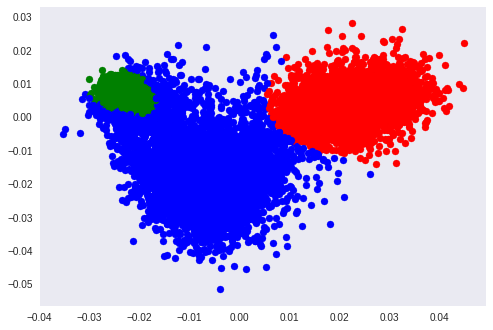

In [0]:
colors=['red','green','blue']
for point,pred in zip(proj,predictions):
  plt.scatter(point[0],point[1],color=colors[pred])
plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


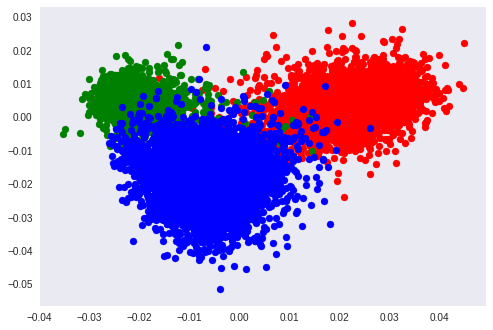

In [0]:
colors=['red','green','blue']
for point,pred in zip(proj,labels):
  plt.scatter(point[0],point[1],color=colors[pred])
plt.show()

In [0]:
a = np.array([[2,4],[1,2],[3,6]])
a

array([[2, 4],
       [1, 2],
       [3, 6]])

In [0]:
new_means = []
for _,arr in means.items():
  #print(arr)
  new_means.append(arr)
 
new_means = np.asarray(new_means)
print(new_means.shape)

(3, 2)


In [0]:
for point in a:
  print(np.subtract(point,new_means).shape)

(3, 2)
(3, 2)
(3, 2)


## Notes

LDA does not seem to work very well with larger number of classes. Comparing with Linear Regression, with fewer classes, LDA seem to be better, however, when I increase the number of classes, my implementation shows a significant decrease in performance.


In [0]:
def func(x):
  print(x)
  return x

In [0]:
b = np.array([[8,1,7], [4,3,9], [5,2,6]])
print(b)
np.apply_along_axis(func, 1, b)

[[8 1 7]
 [4 3 9]
 [5 2 6]]
[8 1 7]
[4 3 9]
[5 2 6]


array([[8, 1, 7],
       [4, 3, 9],
       [5, 2, 6]])

## Fishers Linear Discriminant - Intuitio

In [0]:
Ax = np.random.uniform(low=-1.8,high=4.0,size=[50,1])
Ay = np.random.uniform(low=2,high=4.1,size=[50,1])
classA = np.column_stack((Ax,Ay))

Bx = np.random.uniform(low=1.5,high=7.0,size=[50,1])
By = np.random.uniform(low=0.1,high=2.1,size=[50,1])
classB = np.column_stack((Bx,By))

labelA = np.zeros((classA.shape[0]),dtype=np.int8)
labelB = np.ones((classB.shape[0]),dtype=np.int8)
targets = np.append(labelA,labelB,axis=0)

data = np.append(classA,classB,axis=0)
data_dict = {0: classA, 1:classB}

print(data.shape)
print(targets.shape)

(100, 2)
(100,)


In [0]:
Ax = np.random.normal(1.2, 1.0, 50)
Ay = np.random.normal(2.9, 0.3, 50)
classA = np.column_stack((Ax,Ay))

Bx = np.random.normal(3.8, 1.0, 50)
By = np.random.normal(1.6, 0.3, 50)
classB = np.column_stack((Bx,By))

labelA = np.zeros((classA.shape[0]),dtype=np.int8)
labelB = np.ones((classB.shape[0]),dtype=np.int8)
targets = np.append(labelA,labelB,axis=0)

data = np.append(classA,classB,axis=0)
data_dict = {0: classA, 1:classB}

print(data.shape)
print(targets.shape)

(100, 2)
(100,)


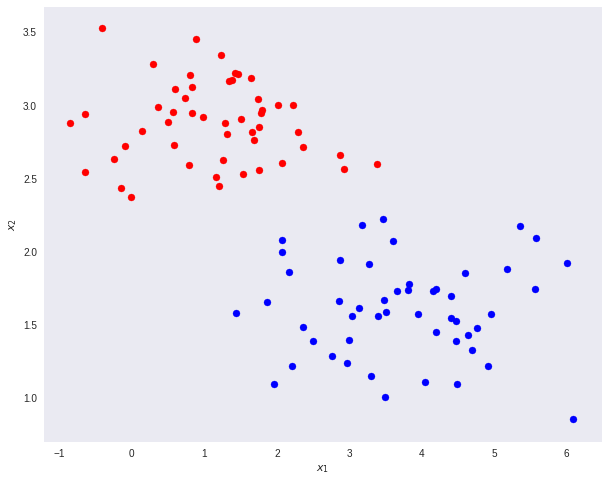

In [0]:
plt.figure(figsize=(10,8))
colors=['red','blue']
for point,pred in zip(data,targets):
  plt.scatter(point[0],point[1],color=colors[pred])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

In [0]:
# compute the mean vector for each of the 2 classes
# compute the mean accros the Bash size dimension
m1 = np.mean(data_dict[0],axis=0)
m2 = np.mean(data_dict[1],axis=0)
print(m1,m2)

[1.11780067 2.88211936] [3.727873  1.6029751]


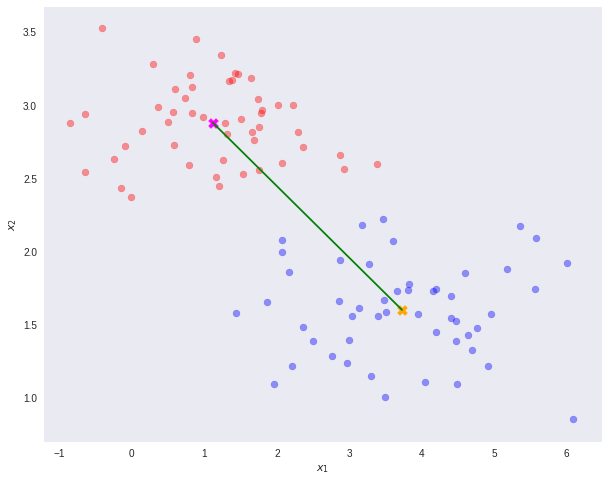

In [0]:
fig, ax = plt.subplots(figsize=(10,8))

colors=['red','blue']
for point,pred in zip(data,targets):
  ax.scatter(point[0],point[1],color=colors[pred], alpha=0.4)

line = mlines.Line2D([m1[0],m2[0]], [m1[1],m2[1]], color='green')
ax.add_line(line)

# plot the mean point of each class
ax.scatter(m1[0],m1[1],color='magenta',s=100,marker="X")
ax.scatter(m2[0],m2[1],color='orange',s=100,marker="X")

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

In [0]:
# find the line that joins to 2 class means
print(m2,m1)
# To find the line that join the 2 class means, we can use the slope-intercept form to find the equation of the line from 2 points. 
sub = np.subtract(m2,m1)
print(sub)
m = sub[1]/sub[0]
print("Slope:,",m)
b = -(m * m1[0]) + m1[1]
print("intercept:",b)

[3.727873  1.6029751] [1.11780067 2.88211936]
[ 2.61007233 -1.27914426]
Slope:, -0.49008000338642127
intercept: 3.4299311131214014


In [0]:
W =np.subtract(m2,m1)
print("Weights:",W)

Weights: [ 2.61007233 -1.27914426]


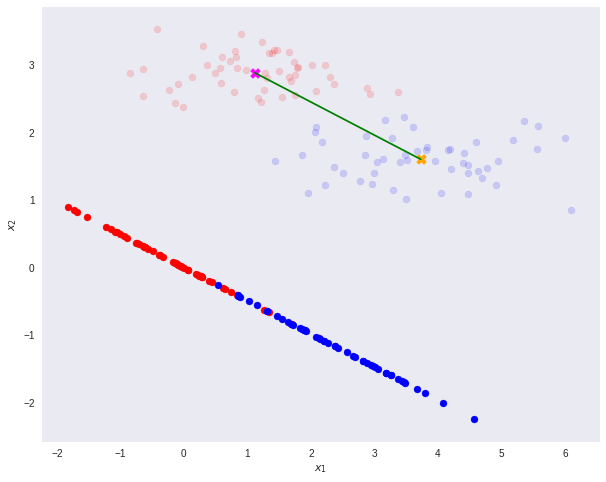

In [0]:
fig, ax = plt.subplots(figsize=(10,8))

colors=['red','blue']
for point,pred in zip(data,targets):
  ax.scatter(point[0],point[1],color=colors[pred], alpha=0.15)
  proj = np.dot(point,W)/np.dot(W,W) * W
  #print(proj.shape)
  ax.scatter(proj[0],proj[1],color=colors[pred])
  
  #y = np.dot(point,W)
  #ax.scatter(y,y,color=colors[pred])
  
# plot the mean point of each class
ax.scatter(m1[0],m1[1],color='magenta',s=100,marker="X")
ax.scatter(m2[0],m2[1],color='orange',s=100,marker="X")

line = mlines.Line2D([m1[0],m2[0]], [m1[1],m2[1]], color='green')
#line = mlines.Line2D([0,W[0]], [0,W[1]], color='red')

#transform = ax.transAxes
#line.set_transform(transform)
ax.add_line(line)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

(50,)


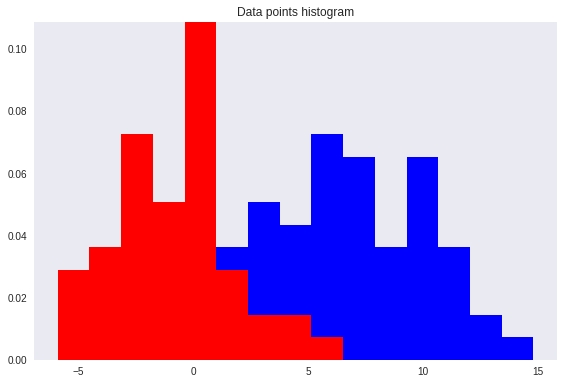

In [0]:
import numpy as np
import matplotlib.pyplot as plt

yA = np.squeeze(np.dot(data_dict[0],np.expand_dims(W,1)))
yB = np.squeeze(np.dot(data_dict[1],np.expand_dims(W,1)))

print(yA.shape)

np.random.seed(0)

n_bins = 15
x = np.random.randn(1000, 2)

fig, axes = plt.subplots(nrows=1, ncols=1)

colors = ['red', 'blue']


axes.hist([yA,yB], n_bins, normed=1, color=colors, histtype='bar', stacked=True)
axes.set_title('Data points histogram')


fig.tight_layout()
plt.show()

In [0]:
# total within-class covariance matrix, given by (4.27)
print("Input vector shape:",data[0].shape)
print("m1.shape",m1.shape)

tmp = np.subtract(data_dict[0], m1)
print("tmp.shape",tmp.shape)
a = np.dot(tmp.T, tmp)

tmp = np.subtract(data_dict[1], m2)
b = np.dot(tmp.T, tmp)
SW = np.add(a,b)

print("Output:",SW.shape)

Input vector shape: (2,)
m1.shape (2,)
tmp.shape (50, 2)
Output: (2, 2)


In [0]:
inv_SW = pinv(SW)
print(inv_SW.shape)
s = m2 - m1
W = np.squeeze(np.dot(inv_SW, np.expand_dims(s,1))) # 
print(W.shape)
print(W)

(2, 2)
(2,)
[ 0.02283786 -0.13944296]


In [0]:
y = np.dot(data,W)
print(y.shape[0])

100


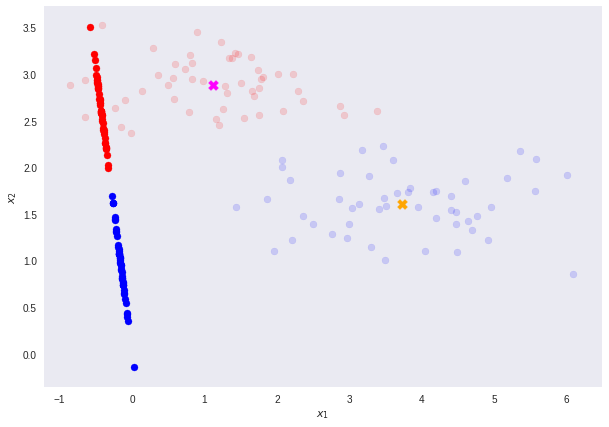

In [0]:
fig, ax = plt.subplots(figsize=(10,7))

colors=['red','blue']
for point,pred in zip(data,targets):
  ax.scatter(point[0],point[1],color=colors[pred],alpha=0.15)
  proj = np.dot(point,W)/np.dot(W,W) * W
  y = np.dot(point,W)

  #print(proj.shape)
  ax.scatter(proj[0],proj[1],color=colors[pred])
  #ax.scatter(y,y,color=colors[pred])

# plot the mean point of each class
ax.scatter(m1[0],m1[1],color='magenta',s=100,marker="X")
ax.scatter(m2[0],m2[1],color='orange',s=100,marker="X")

#line = mlines.Line2D([0,W[0]], [0,W[1]], color='red')
#transform = ax.transAxes
#line.set_transform(transform)
#ax.add_line(line)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

In [0]:
np.column_stack((y,y))

array([[-0.12616009, -0.12616009]])

(50,)


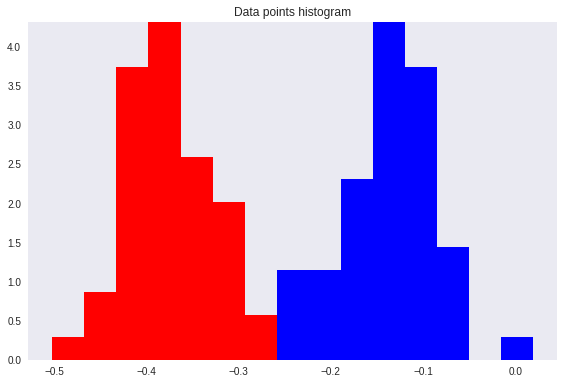

In [0]:
yA = np.squeeze(np.dot(data_dict[0],np.expand_dims(W,1)))
yB = np.squeeze(np.dot(data_dict[1],np.expand_dims(W,1)))

print(yA.shape)

np.random.seed(0)

n_bins = 15

fig, axes = plt.subplots(nrows=1, ncols=1)

colors = ['red', 'blue']
axes.hist([yA,yB], n_bins, normed=1, color=colors, histtype='bar', stacked=True)
axes.set_title('Data points histogram')


fig.tight_layout()
plt.show()

## Polinomial Regression

In [0]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


Text(0,0.5,'$x_2$')

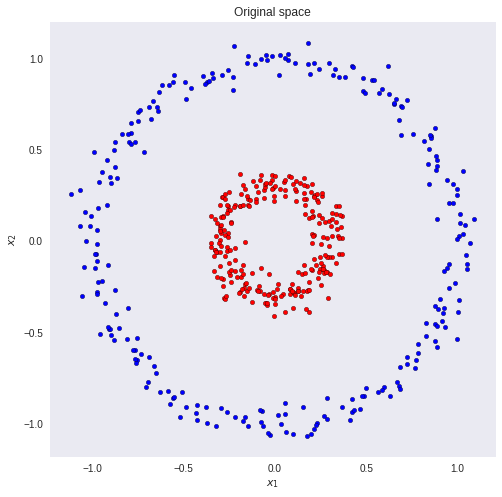

In [0]:
np.random.seed(0)

X, y = make_circles(n_samples=500, factor=.3, noise=.05)

# Plot results
plt.figure(figsize=(8,8))
plt.subplot(1, 1, 1, aspect='equal')
plt.title("Original space")
reds = y == 0
blues = y == 1

plt.scatter(X[reds, 0], X[reds, 1], c="blue",s=20, edgecolor='k')
plt.scatter(X[blues, 0], X[blues, 1], c="red", s=20, edgecolor='k')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
clf = LogisticRegression().fit(X_train, y_train)
pred = clf.predict(X_test)
print("Test acc:", np.sum(pred==y_test))

Test acc: 45


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


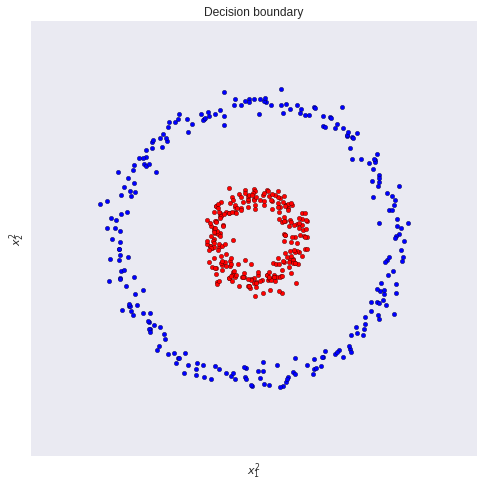

In [0]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .01  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])


# Put the result into a color plot
cmap = plt.get_cmap('bwr')
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(8, 8))
#plt.pcolormesh(xx, yy, Z, cmap=cmap, alpha=0.1)

# Plot also the training points

plt.scatter(X[reds, 0], X[reds, 1], c="blue",s=20, edgecolor='k')
plt.scatter(X[blues, 0], X[blues, 1], c="red", s=20, edgecolor='k')
plt.title("Decision boundary")
plt.xlabel("$x_1^2$")
plt.ylabel("$x_2^2$")

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

In [0]:
# transform the data
X_train = X_train**2
X_test = X_test**2

In [0]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
clf = LogisticRegression().fit(X_train, y_train)
pred = clf.predict(X_test)
print("Test acc:", np.sum(pred==y_test))

Test acc: 100


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


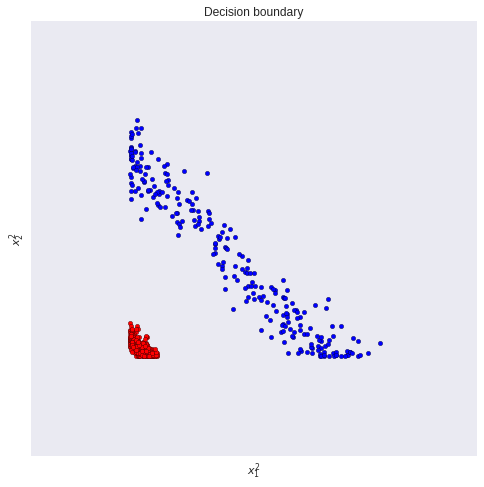

In [0]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(8, 8))
# plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[reds, 0], X[reds, 1], c="blue",s=20, edgecolor='k')
plt.scatter(X[blues, 0], X[blues, 1], c="red", s=20, edgecolor='k')
plt.title("Decision boundary")
plt.xlabel("$x_1^2$")
plt.ylabel("$x_2^2$")

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()